# Goal

* Based on scRecounter cell counts and SRA metadata on dataset release dates, assess the cell counts over time for SRA

# Goal

* Based on scRecounter cell counts and SRA metadata on dataset release dates, assess the cell counts over time for SRA

In [59]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from pypika import Query, Table, functions as fn
from SRAgent.db.connect import db_connect
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [60]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [61]:
# set number of columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

In [62]:
def pandas_complete(df: pd.DataFrame, 
                    group_cols: list, 
                   fill_cols: dict = None, 
                   fill_value: float = 0) -> pd.DataFrame:
    """
    Equivalent of tidyr::complete - fills missing combinations of grouping variables.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    group_cols : list
        List of column names to create combinations from
    fill_cols : dict, optional
        Dictionary mapping column names to fill values for missing combinations.
        If None, all non-grouping columns will be filled with fill_value
    fill_value : float, default 0
        Default value to fill missing combinations with
        
    Returns:
    --------
    pd.DataFrame
        Complete dataframe with all combinations and filled values
        
    Example:
    --------
    # Fill missing combinations with 0 for 'count' column
    df_complete = pandas_complete(df, 
                                 group_cols=['year', 'category'], 
                                 fill_cols={'count': 0})
    
    # Fill all non-grouping columns with 0
    df_complete = pandas_complete(df, group_cols=['year', 'category'])
    """
    import itertools
    
    # Get unique values for each grouping column
    unique_values = [df[col].unique() for col in group_cols]
    
    # Create all possible combinations
    all_combinations = list(itertools.product(*unique_values))
    df_complete = pd.DataFrame(all_combinations, columns=group_cols)
    
    # Merge with original data
    df_merged = df_complete.merge(df, on=group_cols, how='left')
    
    # Fill missing values
    if fill_cols is None:
        # Fill all non-grouping columns with fill_value
        non_group_cols = [col for col in df_merged.columns if col not in group_cols]
        fill_dict = {col: fill_value for col in non_group_cols}
    else:
        fill_dict = fill_cols
    
    df_result = df_merged.fillna(fill_dict)
    
    return df_result


# Get release dates

In [63]:
# obtaining the release dates using the SRAgent utility script
#exe = base_dir.parent / "SRAgent" / "scripts" / "get-srx-date.py"
#!{exe} --help

In [64]:
# run the script to get the release dates
release_date_file = base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
#!{exe} --tenant prod --use-db --output {release_date_file}

In [65]:
df_release_dates = pd.read_csv(release_date_file)
df_release_dates

,srx_accession,release_date
0,SRX7016897,2019-10-18
1,SRX7016896,2019-10-18
...,...,...
58855,SRX28717889,NaN
58856,SRX24000343,NaN


In [66]:
# number NaN for release_date
df_release_dates["release_date"].isna().sum()

41

# Get scRecounter cell counts 

In [67]:
# set tenant
os.environ["DYNACONF"] = "prod"

In [68]:
def get_screcounter_star_results(
    conn, 
    feature="GeneFull_Ex50pAS"
):
    """
    Get the screcounter_star_results table
    
    Args:
        conn: A database connection object (e.g., sqlite3, psycopg2, etc.)
        feature: String of the feature to filter on
    Returns:
        A pandas DataFrame of records
    """
    
    # Define tables
    meta_table = Table('srx_metadata')
    star_table = Table('screcounter_star_results')
    
    # Build the star query with feature filter (case insensitive)
    star_query = (
        Query.from_(star_table)
        .select('*')
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )

    #return pd.read_sql_query(str(star_query), conn)
    
    # Build the main query with join
    # Assuming you want all columns from both tables except feature from star and _at columns from meta
    main_query = (
        Query.from_(star_table)
        .join(meta_table)
        .on(star_table.sample == meta_table.srx_accession)
        .select(
            star_table.sample.as_('srx_accession'),
            star_table.feature,
            star_table.estimated_number_of_cells,
            star_table.median_reads_per_cell,
            star_table.median_umi_per_cell,
            star_table.median_feature_per_cell,
            meta_table.lib_prep,
            meta_table.tech_10x,
            meta_table.organism,
            meta_table.tissue,
            meta_table.tissue_ontology_term_id,
            meta_table.cell_prep
        )
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )
    
    # Execute query and return as DataFrame
    return pd.read_sql_query(str(main_query), conn)

with db_connect() as conn:
    df_cells = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell
...,...,...,...,...,...,...,...,...,...,...,...,...
61602,ARC0000375,GeneFull_Ex50pAS,2096,37854.0,6472.0,2282.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell
61603,ARC0000376,GeneFull_Ex50pAS,1040,20918.0,5256.0,2070.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell


# Join

In [69]:
# merge the two dataframes
df_cells = df_cells.merge(df_release_dates, on="srx_accession", how="left")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61602,ARC0000375,GeneFull_Ex50pAS,2096,37854.0,6472.0,2282.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaN
61603,ARC0000376,GeneFull_Ex50pAS,1040,20918.0,5256.0,2070.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaN


In [70]:
# missing release_date
df_cells["release_date"].isna().sum()

2788

In [71]:
# format
## convert release_date to datetime
df_cells["release_date"] = pd.to_datetime(df_cells["release_date"])
## bin release date by month
df_cells["release_date_month"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('M')
## bin release date by year
df_cells["release_date_year"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('Y')
## if tech_10x == "not_applicable", set to "other"
df_cells["tech_10x"] = df_cells["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
# show 
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29,2023-06,2023
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26,2023-09,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61602,ARC0000375,GeneFull_Ex50pAS,2096,37854.0,6472.0,2282.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaT,NaT,NaT
61603,ARC0000376,GeneFull_Ex50pAS,1040,20918.0,5256.0,2070.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaT,NaT,NaT


# Summarize

## Culm cell count by year

### By tech_10x

In [72]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,tech_10x,estimated_number_of_cells
0,2019,3_prime_gex,21936
1,2019,5_prime_gex,136491
...,...,...,...
48,2025,other,3214399
49,2025,vdj,146838


In [73]:
# Check: sum the number of cells
df_cells_sum["estimated_number_of_cells"].sum()

486699437

In [74]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(['tech_10x', 'release_date_year'])  # Ensure proper ordering
    .groupby('tech_10x')['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[['release_date_year', 'tech_10x']], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,tech_10x
0,21936,2019,3_prime_gex
3,8975810,2020,3_prime_gex
...,...,...,...
40,3056172,2024,vdj
49,3203010,2025,vdj


In [75]:
# add total number of cells to the table
df = df_cells_sum.groupby(["release_date_year"]).sum().reset_index()
df["tech_10x"] = "Total"
df_cells_sum = pd.concat([df_cells_sum, df])
df_cells_sum

,estimated_number_of_cells,release_date_year,tech_10x
0,21936,2019,3_prime_gex
3,8975810,2020,3_prime_gex
...,...,...,...
5,433941879,2024,Total
6,486692027,2025,Total


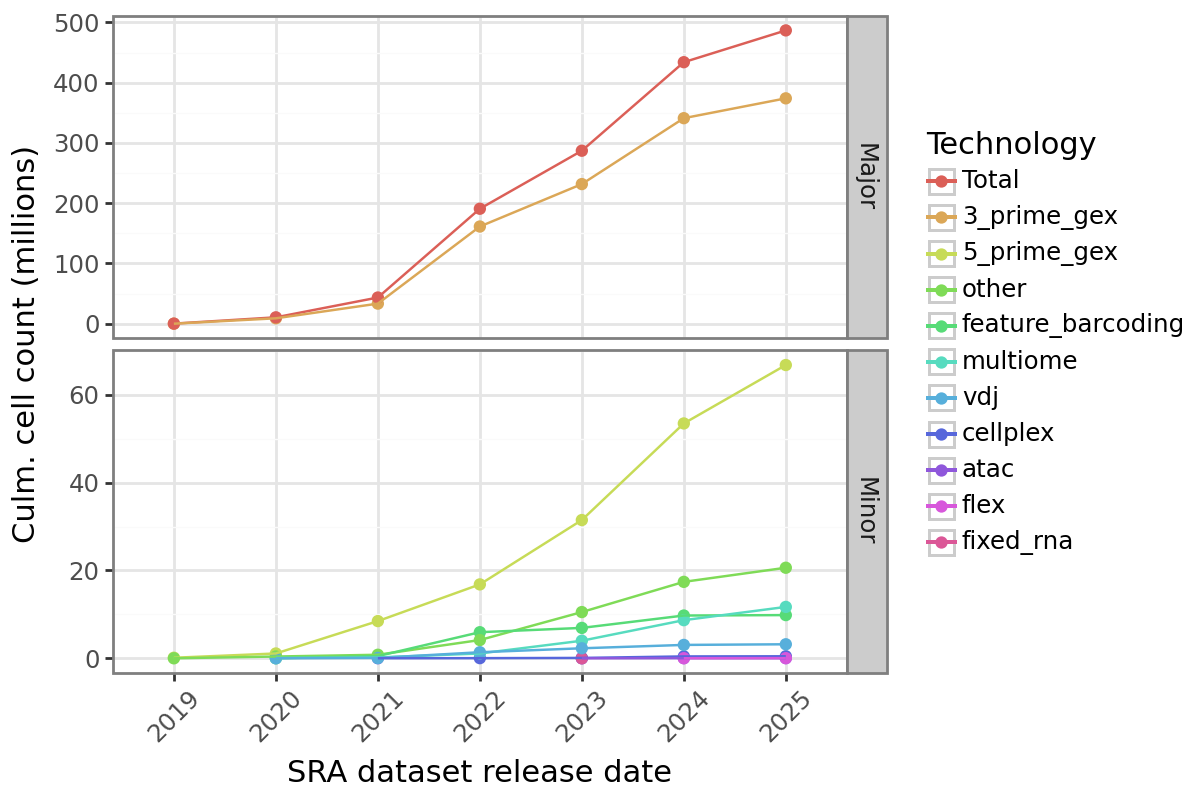

In [76]:
color_dict = {
    'Total': '#000000',
    '3_prime_gex': '#1f77b4',
    '5_prime_gex': '#ff7f0e', 
    'atac': '#2ca02c',
    'cellplex': '#d62728',
    'feature_barcoding': '#9467bd',
    'fixed_rna': '#8c564b',
    'flex': '#e377c2',
    'multiome': '#7f7f7f',
    'other': '#bcbd22',
    'vdj': '#17becf'
}

# copy for editing
df = df_cells_sum.copy()

# order by tech_10x
df_cnt_sum = df.groupby("tech_10x").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False)
tech_10x_order = df_cnt_sum["tech_10x"].unique().tolist()
df["tech_10x"] = pd.Categorical(df["tech_10x"], categories=tech_10x_order)

df["facet"] = df["tech_10x"].apply(lambda x: "Major" if x in ["Total", "3_prime_gex"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tech_10x")) +
    #pn.scale_y_log10() +
    pn.facet_grid("facet ~ .", scales="free_y") +
    # pn.scale_color_manual(
    #     values=color_dict,
    # ) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    )
)
p

In [77]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tech.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech.svg


### By tech_10x and lib_prep

In [78]:
group_cols = ["release_date_year", "tech_10x", "cell_prep"]

In [79]:
# summarize cells by groups
df_cells_sum = df_cells.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,tech_10x,cell_prep,estimated_number_of_cells
0,2019,3_prime_gex,single_cell,21936
1,2019,5_prime_gex,single_cell,136491
...,...,...,...,...
86,2025,other,single_nucleus,198368
87,2025,vdj,single_cell,146838


In [80]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,tech_10x,cell_prep
0,21936,2019,3_prime_gex,single_cell
1,136491,2019,5_prime_gex,single_cell
...,...,...,...,...
86,1953528,2025,other,single_nucleus
87,3203010,2025,vdj,single_cell


In [81]:
# add total number of cells to the table
df = df_cells_sum.groupby(["release_date_year", "cell_prep"]).sum().reset_index()
df["tech_10x"] = "Total"
df_cells_sum = pd.concat([df_cells_sum, df])
df_cells_sum

,estimated_number_of_cells,release_date_year,tech_10x,cell_prep
0,21936,2019,3_prime_gex,single_cell
1,136491,2019,5_prime_gex,single_cell
...,...,...,...,...
16,34817364,2025,Total,single_nucleus
17,523269,2025,Total,unsure


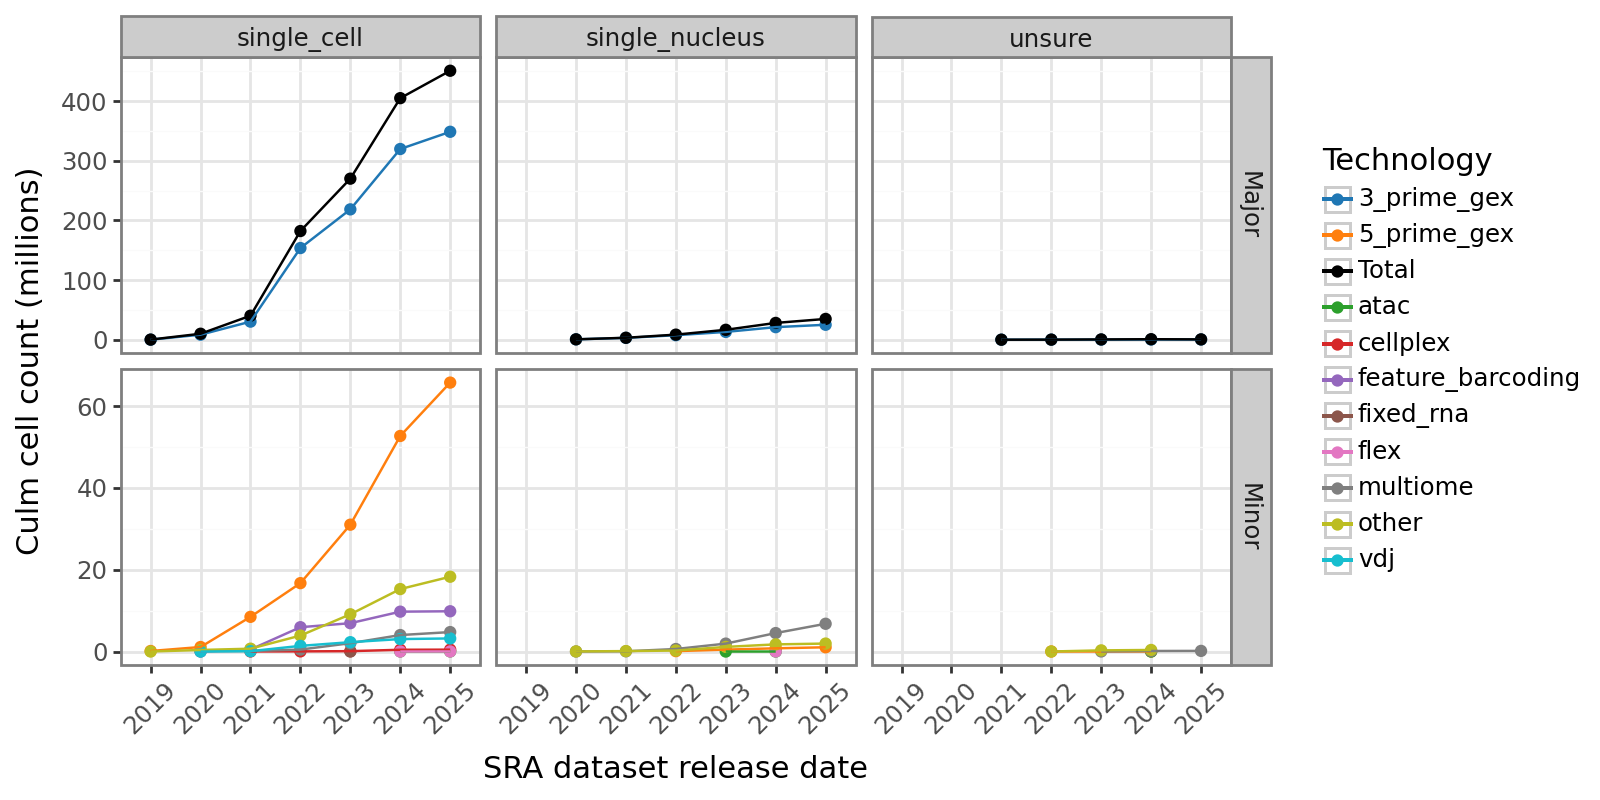

In [82]:
color_dict = {
    'Total': '#000000',
    '3_prime_gex': '#1f77b4',
    '5_prime_gex': '#ff7f0e', 
    'atac': '#2ca02c',
    'cellplex': '#d62728',
    'feature_barcoding': '#9467bd',
    'fixed_rna': '#8c564b',
    'flex': '#e377c2',
    'multiome': '#7f7f7f',
    'other': '#bcbd22',
    'vdj': '#17becf'
}

df = df_cells_sum.copy()
df["facet"] = df["tech_10x"].apply(lambda x: "Major" if x in ["Total", "3_prime_gex"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tech_10x")) +
    #pn.scale_y_log10() +
    pn.facet_grid("facet ~ cell_prep", scales="free_y") +
    pn.scale_color_manual(
        values=color_dict,
    ) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm cell count (millions)",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    )
)
p

### By organism

In [83]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,organism,estimated_number_of_cells
0,2019,Homo sapiens,162935
1,2019,Mus musculus,4971
...,...,...,...
104,2025,Solanum lycopersicum,10877
105,2025,Sus scrofa,439317


In [84]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(['organism', 'release_date_year'])  # Ensure proper ordering
    .groupby('organism')['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[['release_date_year', 'organism']], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,organism
15,135840,2021,Arabidopsis thaliana
33,778109,2022,Arabidopsis thaliana
...,...,...,...
50,202973,2022,Zea mays
71,279544,2023,Zea mays


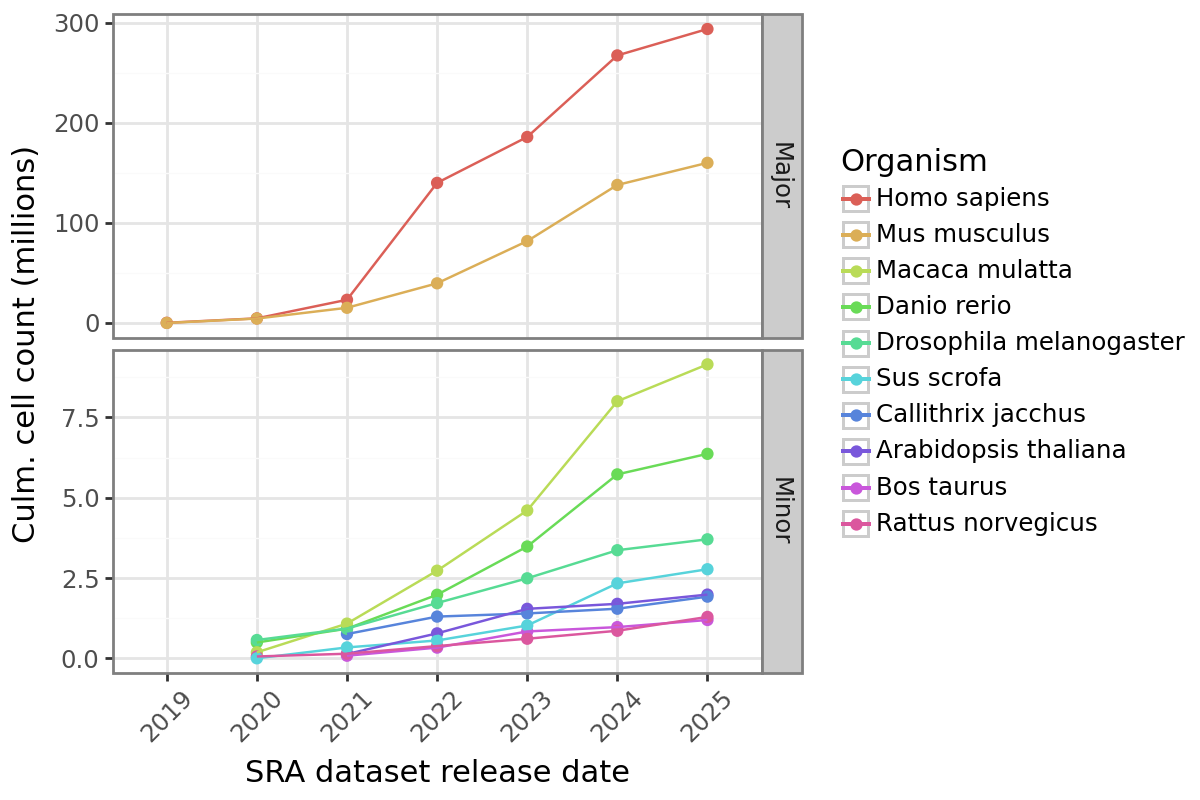

In [85]:
df = df_cells_sum.copy()

# filter to top10 organisms by total cell count
df_top10 = df.groupby("organism").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False).head(10)
df = df[df["organism"].isin(df_top10["organism"])]

# order by organism
organism_order = df_top10["organism"].tolist()
df["organism"] = pd.Categorical(df["organism"], categories=organism_order)

# add facet
df["facet"] = df["organism"].apply(lambda x: "Major" if x in ["Homo sapiens", "Mus musculus"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="organism")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="organism")) +
    pn.facet_grid("facet ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  
    )
)
p

In [86]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_organism.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_organism.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_organism.svg


### By tissue

In [87]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [88]:
df_cells_tissues = df_cells.merge(df_tissue_cats, left_on="tissue", right_on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_cells_tissues["tissue_category"] = df_cells_tissues["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells_tissues

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,tissue_category
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29,2023-06,2023,breast
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26,2023-09,2023,eye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61602,ARC0000375,GeneFull_Ex50pAS,2096,37854.0,6472.0,2282.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaT,NaT,NaT,blood
61603,ARC0000376,GeneFull_Ex50pAS,1040,20918.0,5256.0,2070.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaT,NaT,NaT,blood


In [89]:
group_cols = ["release_date_year", "tissue_category"]

In [90]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,estimated_number_of_cells
0,2019,adipose tissue,4971
1,2019,blood,135612
...,...,...,...
373,2025,vasculature,772464
374,2025,yolk sac,93321


In [91]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category
0,4971,2019,adipose tissue
1,135612,2019,blood
...,...,...,...
373,6372419,2025,vasculature
374,182268,2025,yolk sac


In [92]:
# # add total number of cells to the table
# df = df_cells_tissues_sum.groupby(["release_date_year"]).sum().reset_index()
# df["tech_10x"] = "Total"
# df_cells_tissues_sum = pd.concat([df_cells_tissues_sum, df])
# df_cells_tissues_sum

/tmp/ipykernel_2132715/2690258807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2132715/2690258807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


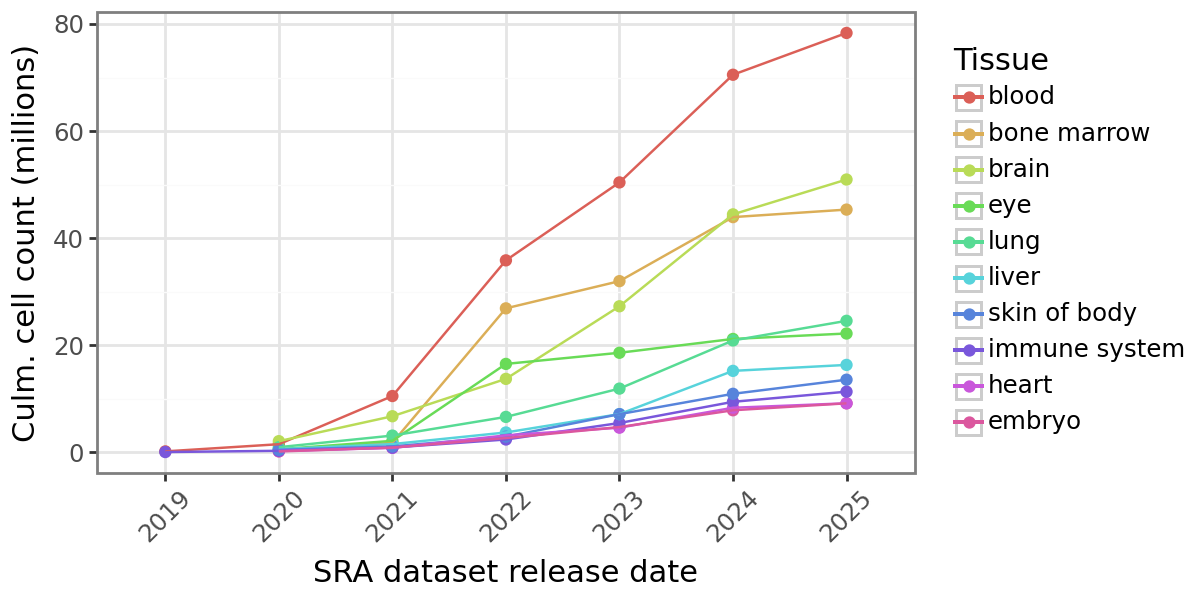

In [93]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 3),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [94]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues.svg


### tissues for human and mouse

In [95]:
group_cols = ["release_date_year", "tissue_category", "organism"]

In [96]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2019,adipose tissue,Mus musculus,4971
1,2019,blood,Homo sapiens,135612
...,...,...,...,...
1071,2025,yolk sac,Macaca mulatta,67206
1072,2025,yolk sac,Mus musculus,26115


In [97]:
# filter to just human and mouse
target_organisms = ["Homo sapiens", "Mus musculus"]
df_cells_tissues_sum = df_cells_tissues_sum[df_cells_tissues_sum["organism"].isin(target_organisms)]
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2019,adipose tissue,Mus musculus,4971
1,2019,blood,Homo sapiens,135612
...,...,...,...,...
1069,2025,vasculature,Mus musculus,304238
1072,2025,yolk sac,Mus musculus,26115


In [98]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,organism
0,4971,2019,adipose tissue,Mus musculus
1,135612,2019,blood,Homo sapiens
...,...,...,...,...
1069,2756696,2025,vasculature,Mus musculus
1072,90835,2025,yolk sac,Mus musculus


/tmp/ipykernel_2132715/2383468987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2132715/2383468987.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


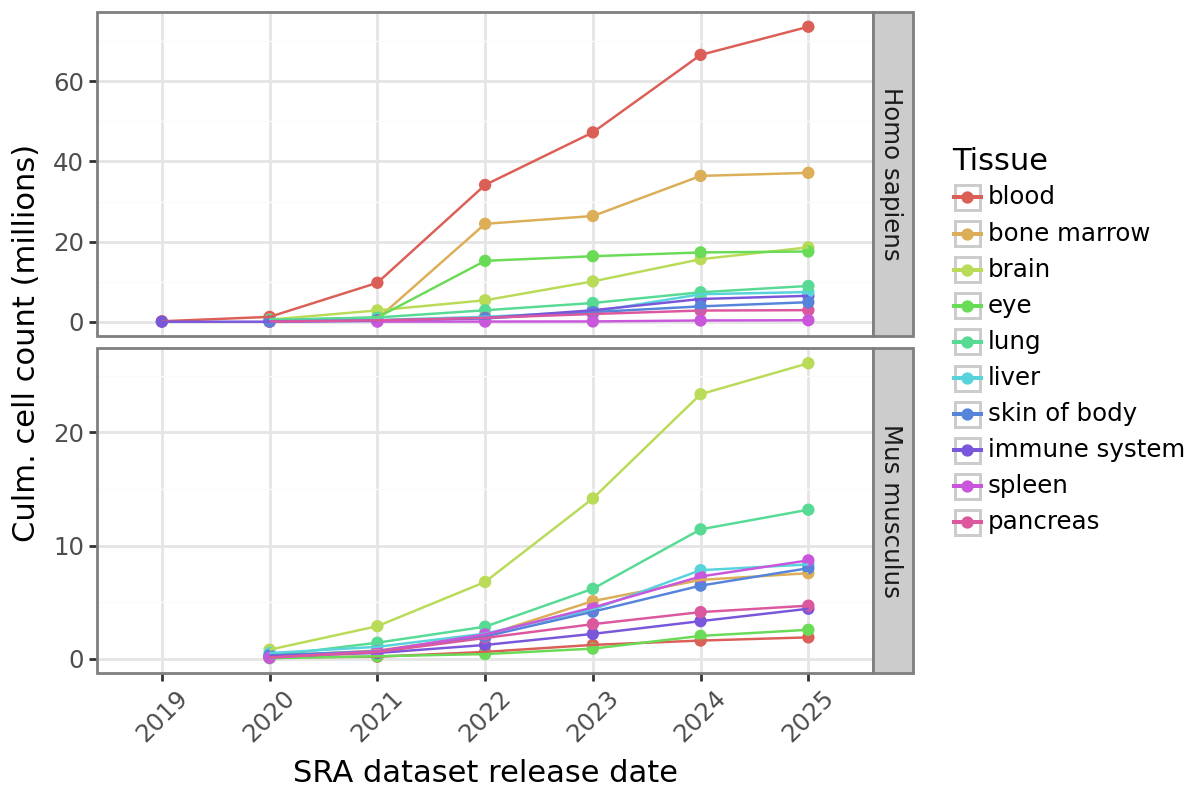

In [99]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [100]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


In [101]:
# check on cell counts per organism/tissue
df = df_cells_tissues[(df_cells_tissues["organism"].isin(["Homo sapiens", "Mus musculus"])) & (df_cells_tissues["tissue"] == "blood")]
df = df.groupby(["organism", "tissue_category"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df

,organism,tissue_category,estimated_number_of_cells
0,Homo sapiens,blood,10524163
1,Mus musculus,blood,753087


## By tissue and tech_10x

In [102]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [103]:
# merge with tissue categories
df_cells_tissues = df_cells.merge(df_tissue_cats, left_on="tissue", right_on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_cells_tissues["tissue_category"] = df_cells_tissues["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells_tissues

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,tissue_category
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29,2023-06,2023,breast
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26,2023-09,2023,eye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61602,ARC0000375,GeneFull_Ex50pAS,2096,37854.0,6472.0,2282.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaT,NaT,NaT,blood
61603,ARC0000376,GeneFull_Ex50pAS,1040,20918.0,5256.0,2070.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,NaT,NaT,NaT,blood


In [104]:
# select groups
group_cols = ["release_date_year", "tissue_category", "tech_10x"]

In [105]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,tech_10x,estimated_number_of_cells
0,2019,adipose tissue,3_prime_gex,4971
1,2019,blood,3_prime_gex,7028
...,...,...,...,...
998,2025,vasculature,other,40890
999,2025,yolk sac,3_prime_gex,93321


In [106]:
# add zeros via pandas_complete
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=group_cols, 
    fill_cols={"estimated_number_of_cells": 0}
)
df_cells_tissues_sum

,release_date_year,tissue_category,tech_10x,estimated_number_of_cells
0,2019,adipose tissue,3_prime_gex,4971.0
1,2019,adipose tissue,5_prime_gex,0.0
...,...,...,...,...
5108,2025,seedling,atac,0.0
5109,2025,seedling,flex,0.0


In [107]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,tech_10x
50,0.0,2019,abdomen,3_prime_gex
51,0.0,2019,abdomen,5_prime_gex
...,...,...,...,...
5052,0.0,2025,yolk sac,other
5055,0.0,2025,yolk sac,vdj


/tmp/ipykernel_2132715/1634206433.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2132715/1634206433.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2132715/1634206433.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


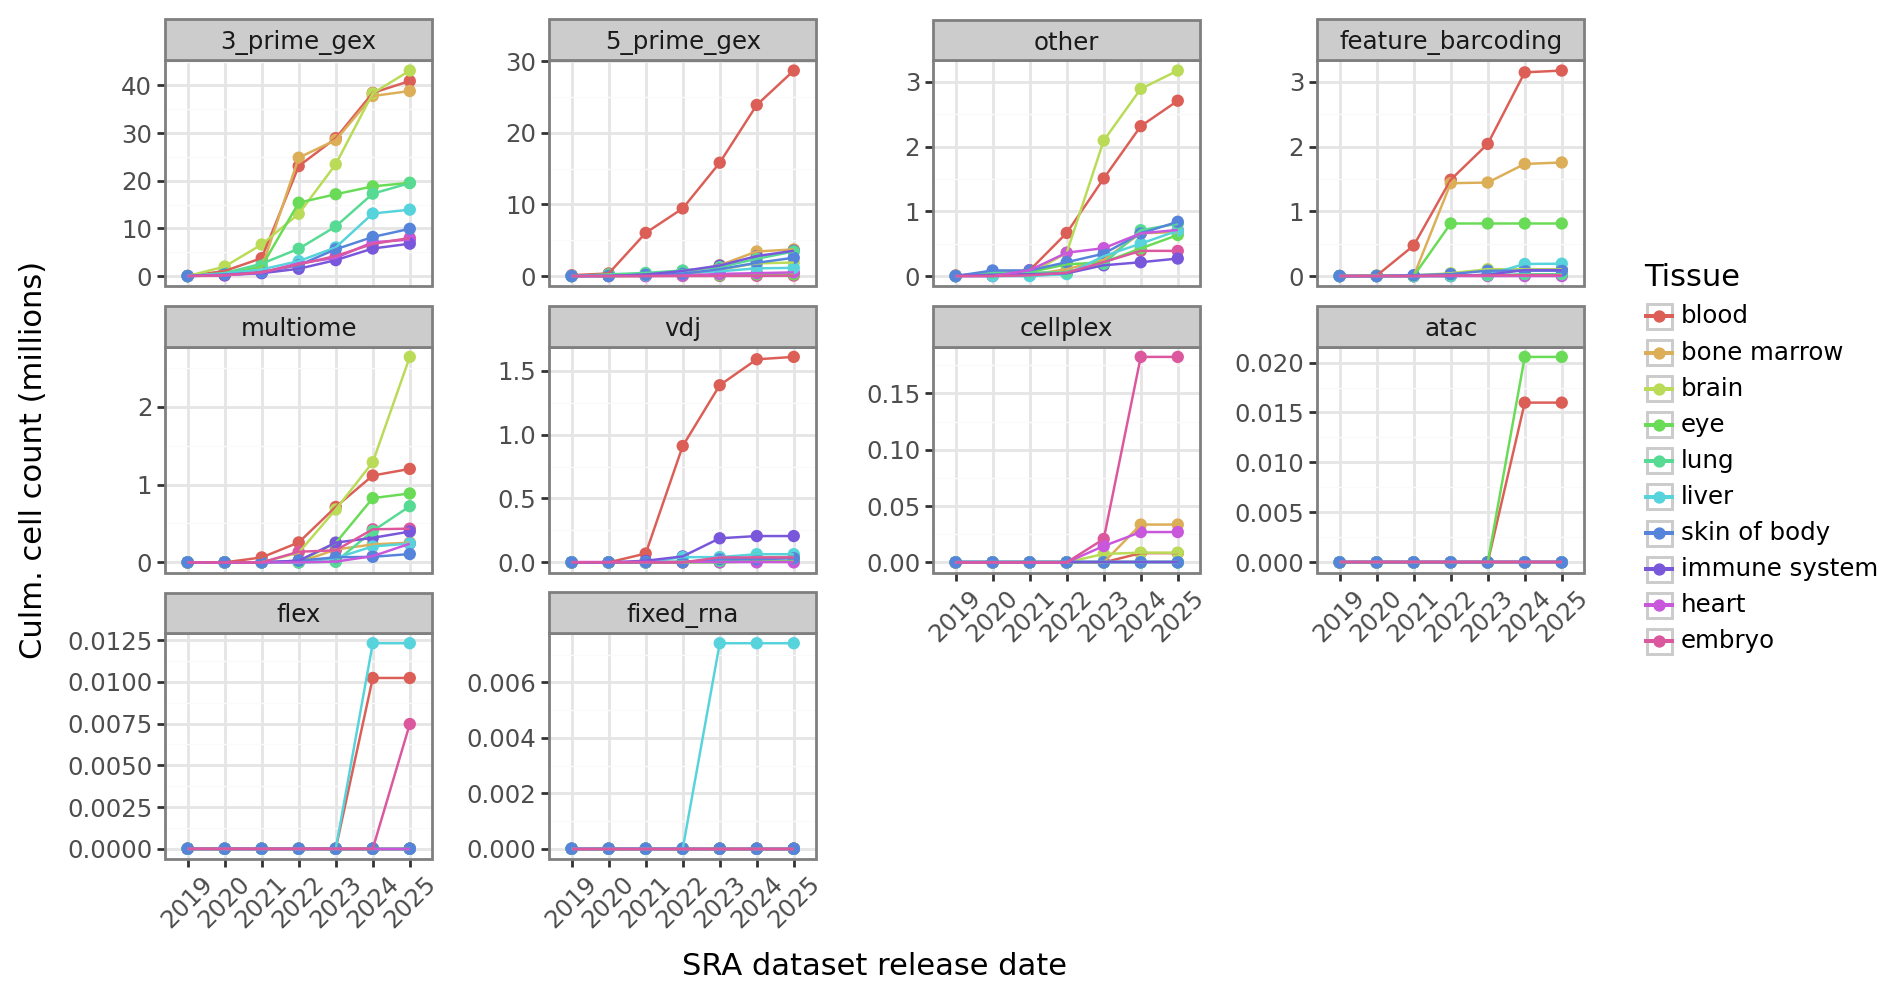

In [108]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "tech_10x", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# filter to top N tech_10x
# df_cells_tissues_sum_top10_tech = (
#     df_cells_tissues_sum[["tech_10x", "estimated_number_of_cells"]]
#     .groupby("tech_10x").sum()
#     .sort_values("estimated_number_of_cells", ascending=False)
#     .head(7)
#     .reset_index()
# )
# df = df[df["tech_10x"].isin(df_cells_tissues_sum_top10_tech["tech_10x"])]

# order by sum of tech_10x by setting tech_10x as Categorical 
df_sum = df.groupby("tech_10x").agg({"estimated_number_of_cells": "sum"}).sort_values("estimated_number_of_cells", ascending=False).reset_index()
df["tech_10x"] = pd.Categorical(df["tech_10x"], categories=df_sum["tech_10x"].tolist())

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6


# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_wrap("tech_10x", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(9.5, 5),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [109]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues-tech.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 9.5 x 5 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech.svg


#### Just top 6

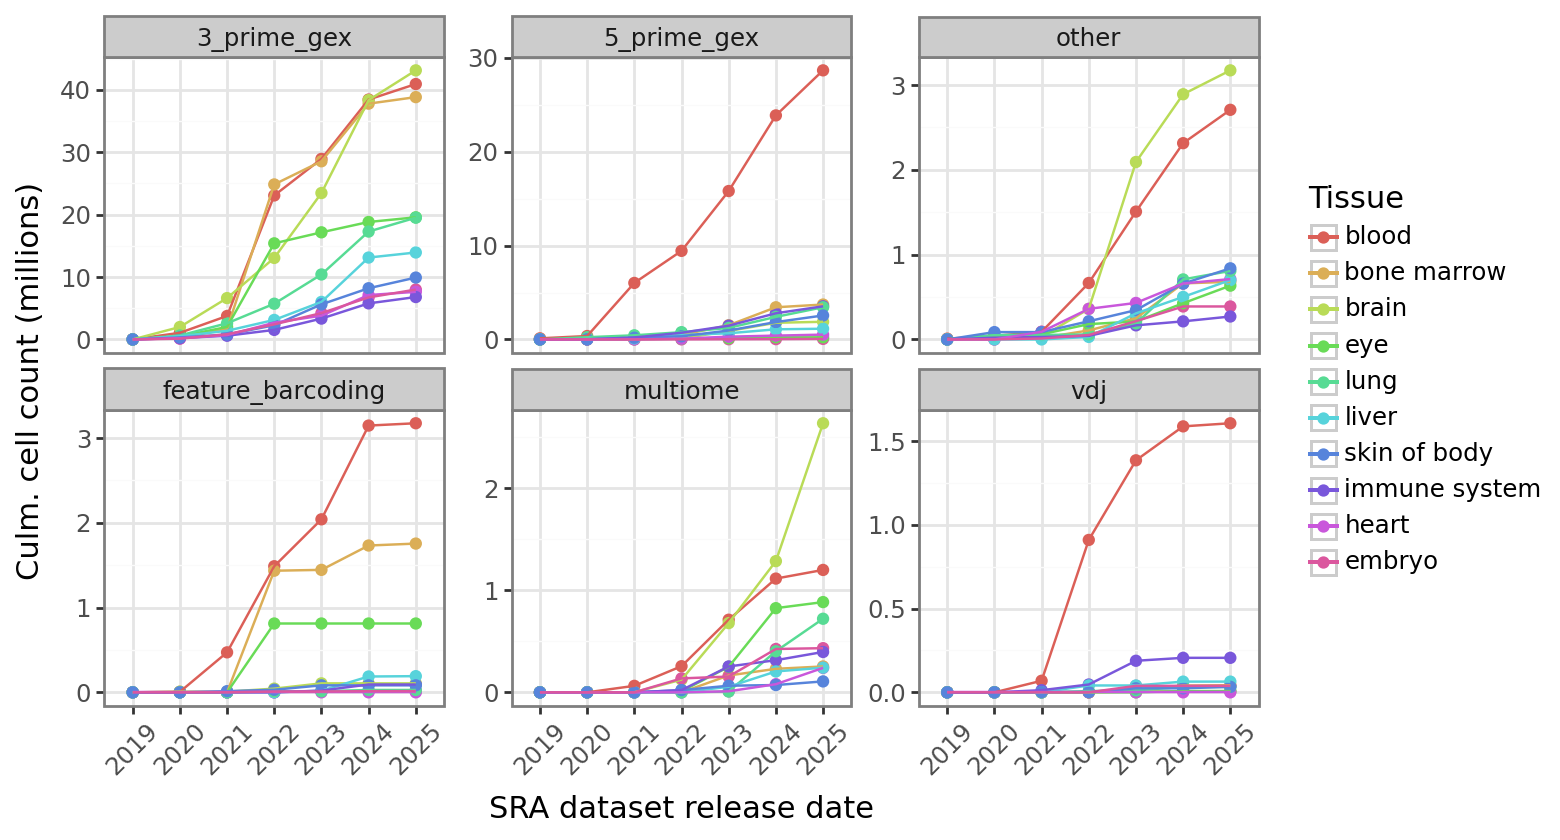

In [110]:
x = ["3_prime_gex", "5_prime_gex", "other", "feature_barcoding", "multiome", "vdj"]

# plot the number of cells over time
p = (
    pn.ggplot(
        df[df["tech_10x"].isin(x)], 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_wrap("tech_10x", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7.8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [111]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues-tech_top6.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech_top6.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech_top6.svg


### tissues for human and mouse

In [112]:
group_cols = ["release_date_year", "tissue_category", "organism"]

In [113]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2019,adipose tissue,Mus musculus,4971
1,2019,blood,Homo sapiens,135612
...,...,...,...,...
1071,2025,yolk sac,Macaca mulatta,67206
1072,2025,yolk sac,Mus musculus,26115


In [114]:
# filter to just human and mouse
target_organisms = ["Homo sapiens", "Mus musculus"]
df_cells_tissues_sum = df_cells_tissues_sum[df_cells_tissues_sum["organism"].isin(target_organisms)]
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2019,adipose tissue,Mus musculus,4971
1,2019,blood,Homo sapiens,135612
...,...,...,...,...
1069,2025,vasculature,Mus musculus,304238
1072,2025,yolk sac,Mus musculus,26115


In [115]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,organism
0,4971,2019,adipose tissue,Mus musculus
1,135612,2019,blood,Homo sapiens
...,...,...,...,...
1069,2756696,2025,vasculature,Mus musculus
1072,90835,2025,yolk sac,Mus musculus


/tmp/ipykernel_2132715/2383468987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2132715/2383468987.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


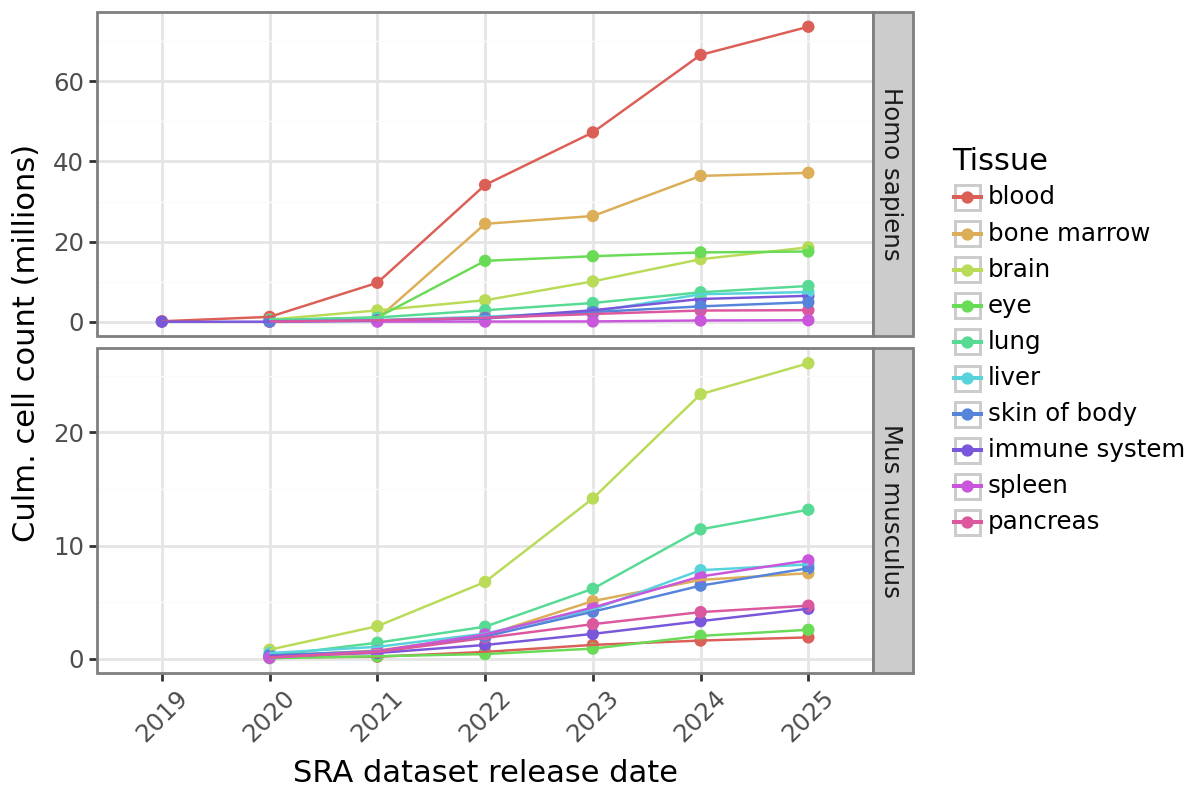

In [116]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [117]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


In [118]:
# check on cell counts per organism/tissue
df = df_cells_tissues[(df_cells_tissues["organism"].isin(["Homo sapiens", "Mus musculus"])) & (df_cells_tissues["tissue"] == "blood")]
df = df.groupby(["organism", "tissue_category"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df

,organism,tissue_category,estimated_number_of_cells
0,Homo sapiens,blood,10524163
1,Mus musculus,blood,753087


***

## Non-culm cell count by time

### By tech_10x and organism

In [277]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index() # if tech_10x == "not_applicable", set to "other"
#
#df_cells_sum = df_cells_sum[df_cells_sum["organism"].isin(["Homo sapiens", "Mus musculus"])]
df_cells_sum["organism"] = df_cells_sum["organism"].apply(lambda x: "other" if x not in ["Homo sapiens", "Mus musculus"] else x)
df_cells_sum["tech_10x"] = df_cells_sum["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
df_cells_sum

,release_date_year,tech_10x,organism,estimated_number_of_cells
0,2019,3_prime_gex,Homo sapiens,16965
1,2019,3_prime_gex,Mus musculus,4971
...,...,...,...,...
250,2025,vdj,other,2200
251,2025,vdj,Mus musculus,11360


In [278]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.copy()
df_cells_sum["organism"] = df_cells_sum["organism"].apply(lambda x: "other" if x not in ["Homo sapiens", "Mus musculus"] else x)
df_cells_sum = df_cells_sum.groupby(["release_date_year", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()

# complete the dataframe
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "tech_10x", "organism"], 
    fill_cols={"estimated_number_of_cells": 0}
)
df_cells_sum

,release_date_year,tech_10x,organism,estimated_number_of_cells
0,2019,3_prime_gex,Homo sapiens,16965.0
1,2019,3_prime_gex,Mus musculus,4971.0
...,...,...,...,...
208,2025,flex,Mus musculus,0.0
209,2025,flex,other,0.0


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


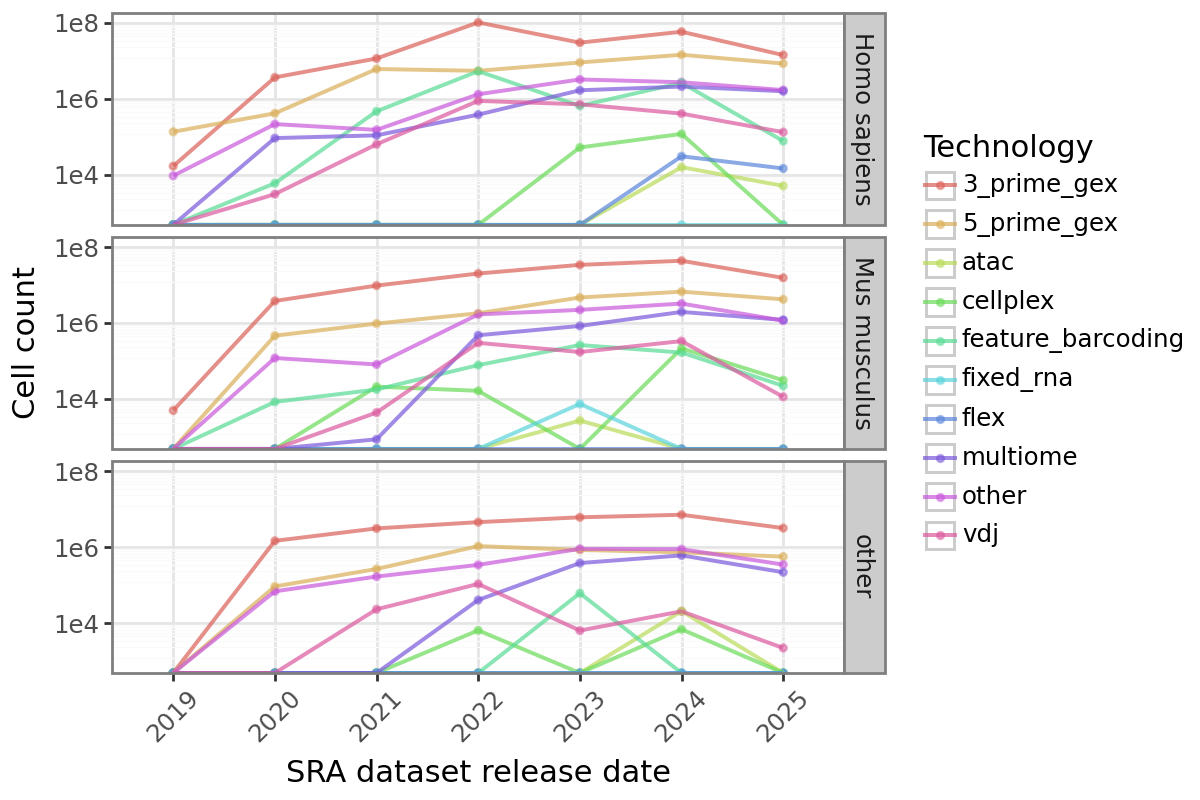

In [279]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point(alpha=0.5, size=0.9) +
    pn.geom_line(pn.aes(group="tech_10x"), alpha=0.7, size=0.8) +
    pn.scale_y_log10() +
    pn.facet_grid("organism ~ .") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Cell count",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [280]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tech-organism.svg"
pn.ggsave(p, outfile)

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech-organism.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


### By tissue: human/mouse

In [281]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-03-11_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
5616,zebrafish embryos,embryo
5617,brain's right hemisphere,brain


In [282]:
# left join on tissue
df_cells_tissue = df_cells.merge(df_tissue_cats, on="tissue", how="left")
# just human/mouse
df_cells_tissue = df_cells_tissue[df_cells_tissue["organism"].isin(["Homo sapiens", "Mus musculus"])]
df_cells_tissue

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,release_date,release_date_month,release_date_year,category
0,SRX27895542,GeneFull_Ex50pAS,10377,6931.0,2020.0,891.0,10x_Genomics,5_prime_gex,Mus musculus,tumor tissue from colon26 model,UBERON:0001155,2025-03-06,2025-03,2025,NaN
1,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,2023-12-13,2023-12,2023,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59553,SRX6479144,GeneFull_Ex50pAS,2459,1458.0,862.0,551.0,10x_Genomics,3_prime_gex,Mus musculus,induced pluripotent stem cells (iPSCs),,NaT,NaT,NaT,other
59554,SRX6479078,GeneFull_Ex50pAS,2519,1602.0,867.0,531.0,10x_Genomics,3_prime_gex,Mus musculus,mouse embryonic fibroblasts (MEFs),,NaT,NaT,NaT,embryo


In [283]:
# summarize cells by year and tech_10x
df_cells_tissue_sum = df_cells_tissue.groupby(
    ["release_date_year",  "organism", "category"]
    ).agg({"estimated_number_of_cells": "sum"}).reset_index() # if tech_10x == "not_applicable", set to "other"
df_cells_tissue_sum = pandas_complete(
    df_cells_tissue_sum, 
    group_cols=["release_date_year", "organism", "category"], 
    fill_cols={"estimated_number_of_cells": 0}
)
df_cells_tissue_sum 

,release_date_year,organism,category,estimated_number_of_cells
0,2019,Homo sapiens,blood,135612.0
1,2019,Homo sapiens,immune system,10875.0
...,...,...,...,...
908,2025,Mus musculus,chest wall,0.0
909,2025,Mus musculus,ureter,0.0


In [284]:
# filter to top 20 tissues
top_tissues = (
    df_cells_tissue_sum
    .groupby("category")
    .agg({"estimated_number_of_cells": "sum"})
    .sort_values(by="estimated_number_of_cells", ascending=False)
    .head(20).index.tolist()
)
# filter
df_cells_tissue_sum = df_cells_tissue_sum[df_cells_tissue_sum["category"].isin(top_tissues)]
df_cells_tissue_sum

,release_date_year,organism,category,estimated_number_of_cells
0,2019,Homo sapiens,blood,135612.0
1,2019,Homo sapiens,immune system,10875.0
...,...,...,...,...
875,2025,Mus musculus,spleen,838808.0
876,2025,Mus musculus,colon,237618.0


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


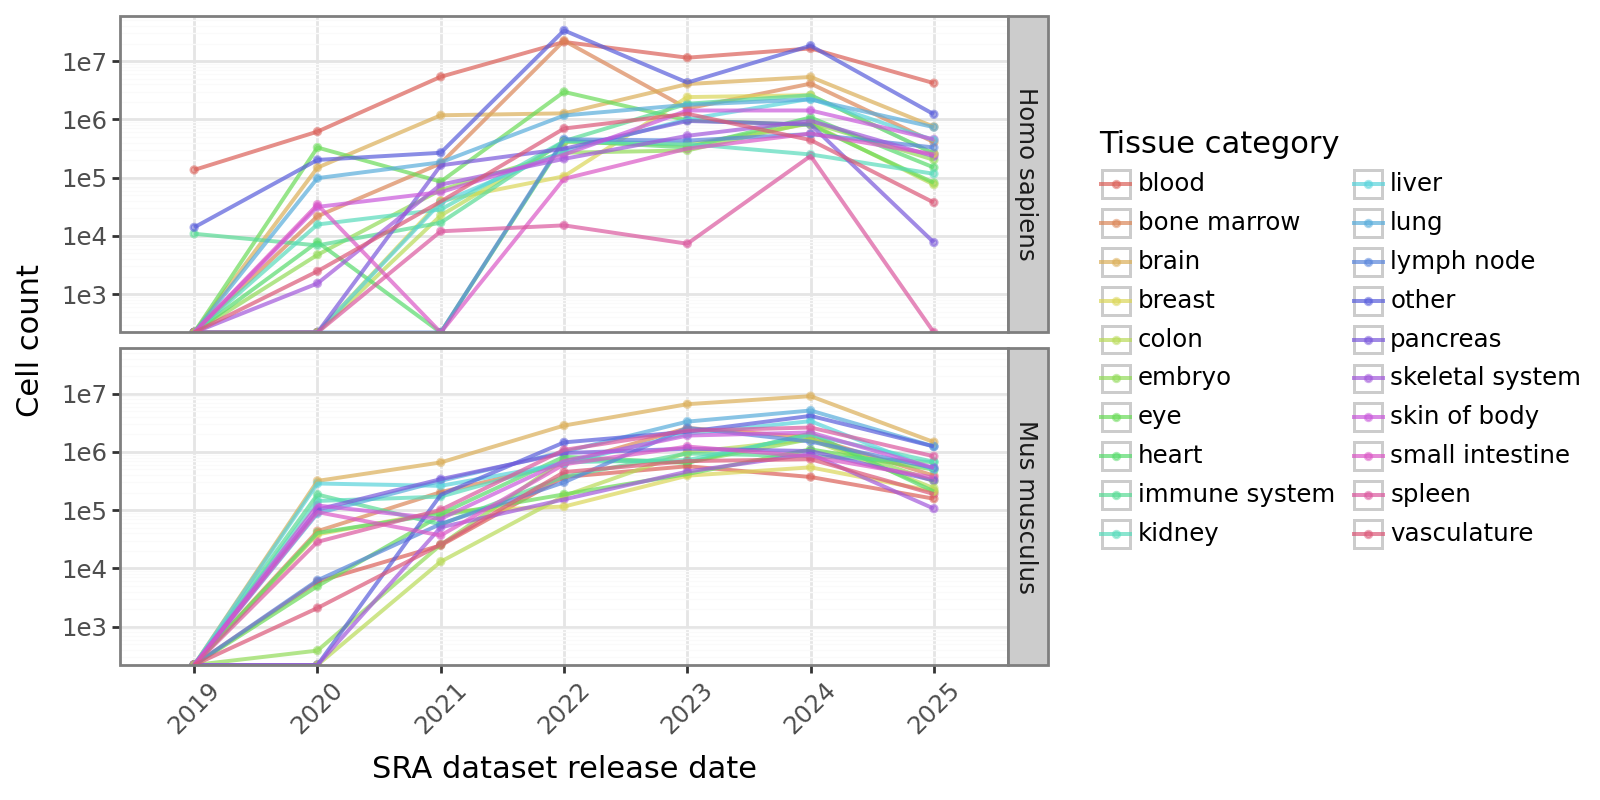

In [285]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_tissue_sum, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="category")
    ) +
    pn.geom_point(alpha=0.5, size=0.9) +
    pn.geom_line(pn.aes(group="category"), alpha=0.7, size=0.8) +
    pn.scale_y_log10() +
    pn.facet_grid("organism ~ .") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Cell count",
        color = "Tissue category",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [286]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissue.svg"
pn.ggsave(p, outfile)

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissue.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


## UMIs per cell

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 739 rows containing non-finite values.


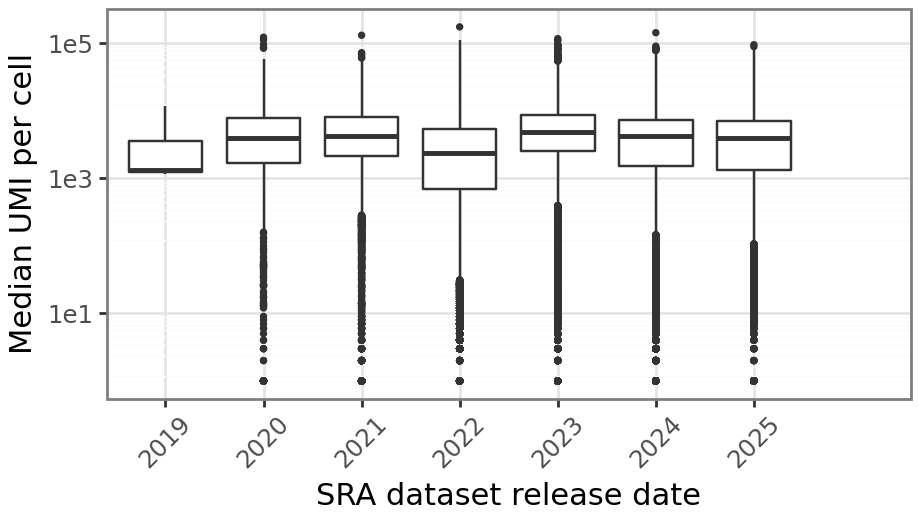

In [287]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_umi_per_cell")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [288]:
# save as svg
outfile = base_dir / "figures" / "sra_umis-by-time.svg"
pn.ggsave(p, outfile)

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 739 rows containing non-finite values.


# Median genes per cell

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 739 rows containing non-finite values.


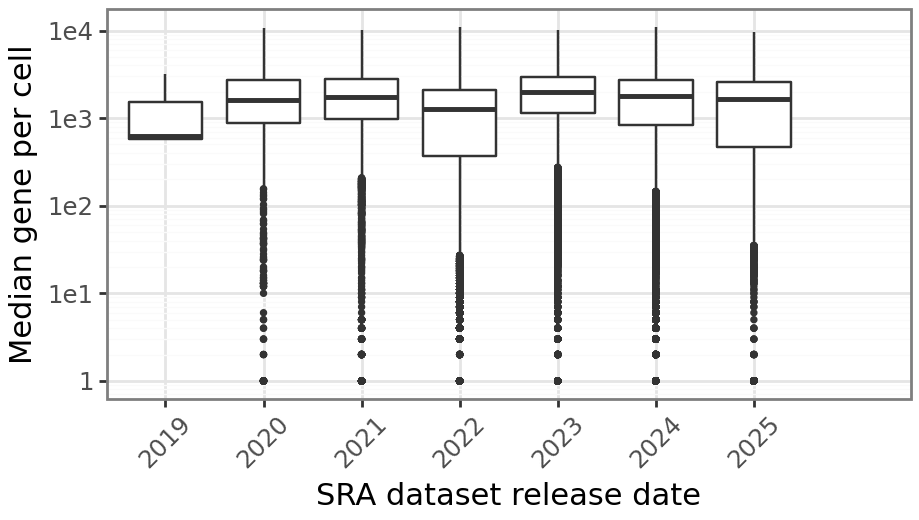

In [289]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_feature_per_cell")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median gene per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [290]:
# save as svg
outfile = base_dir / "figures" / "sra_genes-by-time.svg"
pn.ggsave(p, outfile)

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_genes-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 739 rows containing non-finite values.


## Reads per cell

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 739 rows containing non-finite values.


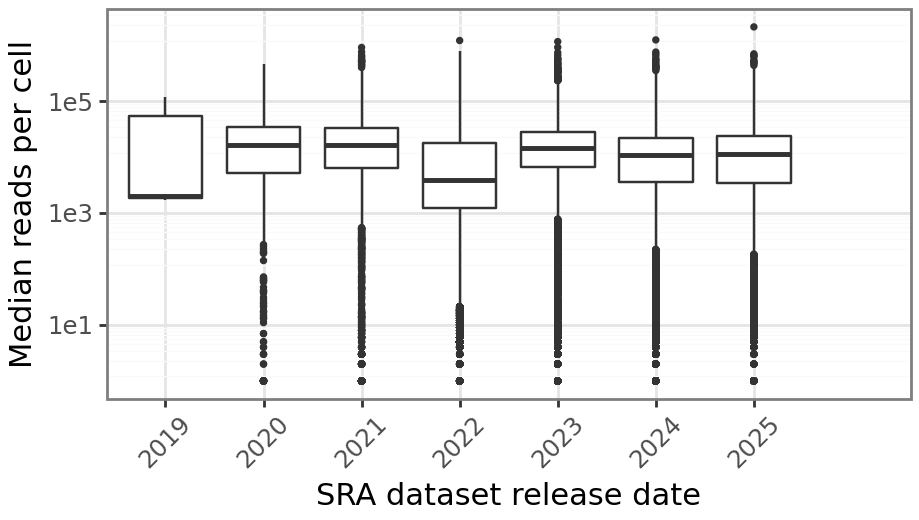

In [291]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_reads_per_cell")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median reads per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [292]:
# save as svg
outfile = base_dir / "figures" / "sra_genes-by-time.svg"
pn.ggsave(p, outfile)

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_genes-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 739 rows containing non-finite values.


# --OLD--

### Cells by month

In [223]:
# summarize cells by month and tech_10x
df_cells_sum = df_cells.groupby(["release_date_month", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
# filter
df_cells_sum = df_cells_sum[df_cells_sum["organism"].isin(["Homo sapiens", "Mus musculus"])]
# if tech_10x == "not_applicable", set to "other"
df_cells_sum["tech_10x"] = df_cells_sum["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
df_cells_sum

,release_date_month,tech_10x,organism,estimated_number_of_cells
0,2019-10,3_prime_gex,Mus musculus,4971
1,2019-11,3_prime_gex,Homo sapiens,16965
...,...,...,...,...
1013,2025-06,multiome,Mus musculus,115088
1016,2025-06,vdj,Homo sapiens,45181


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/p

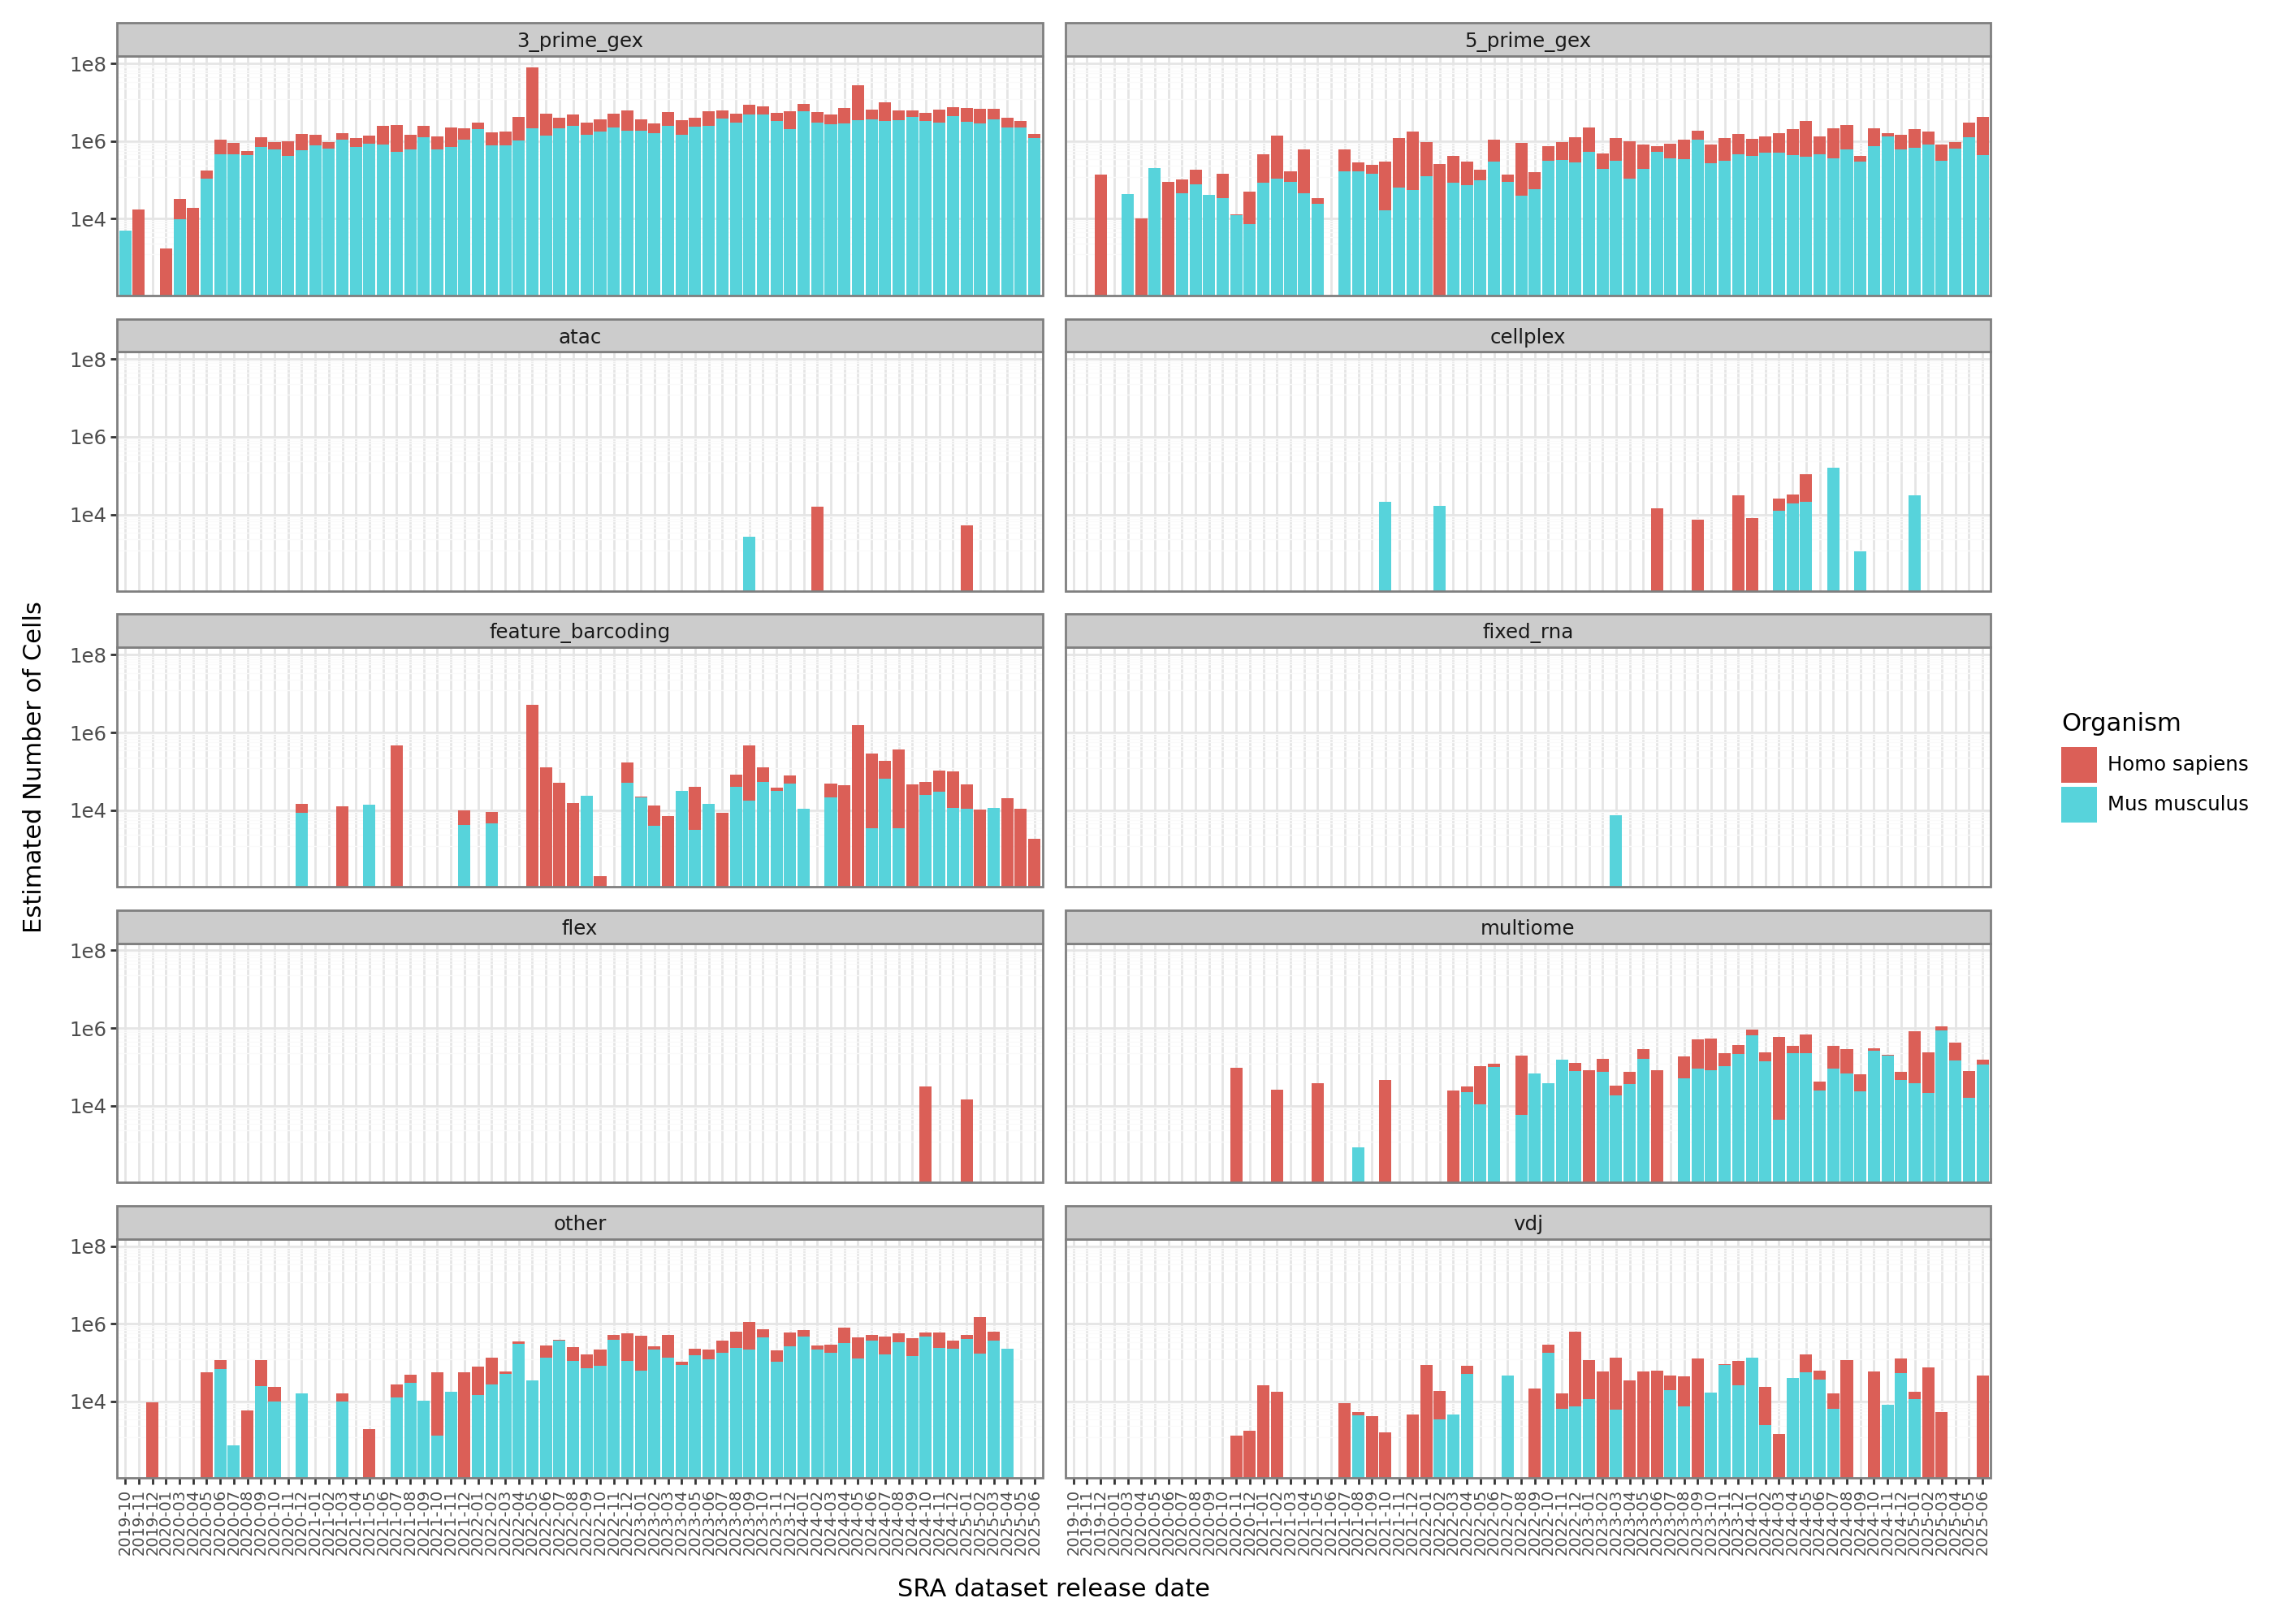

In [224]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_month", y="estimated_number_of_cells", fill="organism")
    ) +
    pn.geom_col() +
    pn.scale_y_log10() +
    pn.facet_wrap("~tech_10x", ncol=2) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Estimated Number of Cells",
        fill = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(14, 10),
        axis_text_x=pn.element_text(angle=90, hjust=0.9, size=7),
    )
)
p